# Measuring the impact of student research labs at the University of Texas 

### pymatch does not work with the new version of pandas. You need to install the pymatch version below: 
    
###    pip install git+https://github.com/mc51/pymatch.git

In [1]:
%%HTML
<style type="text/css">
</style>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import janitor #pyjanitor 
import statsmodels.formula.api as smf
import censusdata 
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [3]:
data = pd.read_excel("IDA Student Info Fall 2018 - Test.xlsx", sheet_name= "Sheet1").clean_names()

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_colwidth', 25)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10599 entries, 0 to 10598
Data columns (total 39 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   sch_maj1                                                        10599 non-null  object 
 1   ut_abbr1                                                        10088 non-null  object 
 2   cola_abbr1                                                      10599 non-null  object 
 3   profiles                                                        10417 non-null  object 
 4   maj1_name                                                       10599 non-null  object 
 5   sch_maj2                                                        2381 non-null   object 
 6   ut_abbr2                                                        2360 non-null   object 
 7   cola_abbr2                                       

# Codebook 
### \*Currently missing columns with individual identifiers\*
| **Variable Name** | **Plain English**|
| --- | --- |
|sch_maj1| School Major |
|ut_abbr1| UT abbreviation |
|cola_abbr1| COLA abbreviation|
|profiles| There's a lot of information in this column that I don't think is important|
|maj1_name| Name of major |
|sch_maj2| Second major|
|ut_abbr2| UT Abbreviation of second major |
|cola_abbr2| COLA abbreviation of second major|
|maj2_name|Second Major Name|
|cumulative_gpa |Cumulative GPA|
|gpa_hrs | GPA hours completed at UT (includes currently taking)|
|credit_hrs_excludes_current_ |Excludes currently taking, but it includes transfer credits|
|current_hrs|Current hours taking this semester|
|perm_street_2|Second Address|
|perm_street_3|Third Address|
|perm_city| Permanent City|
|perm_state| Permanent State|
|perm_postal_code| Postal Code|
|citizenship| Citizenship |
|gender|gender|
|ethnicities| Ethnicities|
|classification| Freshman/Sophmore etc.|
|ut_degrees| UT degrees if they've already been awarded one. (I think)|
|current_ageas_of_today| Current Age as of last draw of the data|
|cumulative_gpa_in_residenceunavailable_if_current_ccyys| Cumulative GPA in residence (unavailable if taking classes this semester)|
|cumulative_hrs_incomplete|Cumulative hours completed|
|cumulative_hrs_transferred|Cumulative hours transfered|
|sem_gpa_fall_2018unavailable_if_current_ccyys|Semester GPA Fall 2018 (unavailable if current semester)|
|sem_gpa_hrs_fall_2018unavailable_if_current_ccyys|Semester GPA and Hours Fall 2018 (unavailable if current semester)|
|overall_act_score| ACT Score|
|sat_verbal_score| SAT Verbal Score |
|sat_quant_score| SAT Quant Score |
|semester_hrs_incomplete_fall_2018_unavailable_if_current_ccyys| Semester hours incomplete (unavailable if current semester)|
|fatherseducation|Father's education|
|motherseducation|Mother's education|
|familyincome|Family income category|
|high_school|High School|
|hs_rank | High School Rank|
|unofficial_hnrs_pgm_s_ |Unofficial Honors Program|
|popestimate2018 | City Population Estimate from the Census |
|c_rating | High School Accountability Rating (TEA) |


# Data Cleaning 

#### UT data

There are 10599 students in the data for 2018. Removing non-texas residents there are 9743. 


**Variables Removed**
* sch_maj1 and maj1_name were removed because I'm using ut_abbr1 
* perm_postal_code was removed because we already have city and high school 

In [4]:
df = data.drop(['sch_maj2', 'ut_abbr2','cola_abbr2','maj2_name','cumulative_gpa_in_residenceunavailable_if_current_ccyys',
             'sem_gpa_fall_2018unavailable_if_current_ccyys','sem_gpa_hrs_fall_2018unavailable_if_current_ccyys',
             'unofficial_hnrs_pgm_s_','semester_hrs_incomplete_fall_2018_unavailable_if_current_ccyys','cumulative_hrs_incomplete', 'ut_degrees', 'cola_abbr1',
              'perm_street_3','perm_street_2','profiles', 'sch_maj1', 'maj1_name', 'perm_postal_code' ], axis=1)

df = df.rename(columns={"credit_hrs_excludes_current_": "credit_hrs_ex_cur", "current_ageas_of_today": "age", "cumulative_hrs_transferred" : "hrs_transferred"})


#converting datatypes to string in order to remove certain values 
df['hs_rank'] = df['hs_rank'].astype(str)
df['overall_act_score'] = df['overall_act_score'].astype(str)
df['age'] = df['age'].astype(str)
df['sat_verbal_score'] = df['sat_verbal_score'].astype(str)
df['sat_quant_score'] = df['sat_quant_score'].astype(str)

#Removing letters from age 
df['age'] = df['age'].str.replace("\(R\)", "")
df['age'] = df['age'].str.replace("\*Minor", "")

#cleaning the college classification
df['classification'] = df['classification'].replace("\(R\)", "")
df = df.replace('unknown', "0/0")
df = df.replace('None', "0")

#changing datatype
df['sat_verbal_score'] = df['sat_verbal_score'].astype(int)
df['sat_quant_score'] = df['sat_quant_score'].astype(int)
df['overall_act_score'] = df['overall_act_score'].astype(int)
df['age'] = df['age'].astype(int)

#Computing HS rank as a percentile
df[['numerator','denominator']] = df.hs_rank.str.split("/",expand=True,)
df['numerator'] = df['numerator'].astype(int)
df['denominator'] = df['denominator'].astype(int)
df['hs_rank'] = df['numerator']/df['denominator']
df['hs_rank'] = df['hs_rank']*100
df = df.drop(['numerator','denominator'], axis = 1)

#There are some additional characters and different spelling that needs to be corrected, and I can remove perm_state after only TX is selected
df = df[df['perm_state'] == 'TX']
df = df.drop(['perm_state'], axis = 1)
df['high_school'] = df['high_school'].str.replace('\d+', '')
df['high_school'] = df['high_school'].str.replace(r" \(.*\)", '')
df['high_school'] = df['high_school'].str.replace('hs', 'High School')
df['high_school'] = df['high_school'].str.replace('h s', 'High School')
df['high_school'] = df['high_school'].str.replace('HS', 'High School')
df['high_school'] = df['high_school'].str.replace('H S', 'High School')
df['high_school'] = df['high_school'].str.replace('Hs', 'High School')
df.loc[(df.high_school == 'Anderson'),'high_school']= 'Anderson High School'

#All the non-numeric characters need to be removed to convert current hours to numeric data type
df['current_hrs'] = 'str' + df['current_hrs'].astype(str)
df['current_hrs'] = df['current_hrs'].str.extract('(\d+)', expand=False)
df['current_hrs'] = df['current_hrs'].astype(float)

df




,ut_abbr1,cumulative_gpa,gpa_hrs,credit_hrs_ex_cur,current_hrs,perm_city,citizenship,gender,ethnicities,classification,age,hrs_transferred,overall_act_score,sat_verbal_score,sat_quant_score,fatherseducation,motherseducation,familyincome,high_school,hs_rank
0,C C,3.1717,68,77,18.0,Lampasas,U. S. Citizen,Male,Black or African Amer...,Junior,20,0,24,550,600,High School Diploma O...,Some College,0/0,Lampasas High School,6.048387
1,HIS,2.0767,43,76,17.0,Austin,U. S. Citizen,Female,Asian,Junior (R),21,35,23,560,590,Graduate Or Professio...,Graduate Or Professio...,H,Westwood High School,69.798658
2,NaN,4.0000,3,3,3.0,Austin,U. S. Citizen,Female,Hispanic,Senior,32,0,0,0,0,Bachelor's Or Four-ye...,Bachelor's Or Four-ye...,C,Homer Hanna High School,NaN
3,IRG,3.5208,34,79,15.0,Spring,U. S. Citizen,Female,"Hispanic, Asian",Junior,20,42,22,660,540,Graduate Or Professio...,Associate's Degree,G,Klein Collins High Sc...,45.080946
4,GOV,0.0000,0,0,13.0,Lewisville,U. S. Citizen,Female,Black or African Amer...,Freshman,18,0,0,700,600,Bachelor's Or Four-ye...,Educational Level Unk...,A,Lewisville High School,7.200720
5,PSY,2.8974,55,64,15.0,Houston,U. S. Citizen,Female,Asian,Junior,20,0,22,630,500,Some High School,Graduate Or Professio...,B,Pasadena Memorial Hig...,4.264099
6,WGS,3.6368,22,23,14.0,Carrollton,U. S. Citizen,Female,Asian,Freshman,19,0,29,0,0,Graduate Or Professio...,Associate's Degree,0/0,Hebron High School,23.240223
7,ECO,3.7487,24,56,13.0,Austin,Non - U. S. Citizen,Female,NaN,Sophomore,20,27,0,530,640,0/0,0/0,0/0,Lyceum School,NaN
8,ECO,3.4375,48,101,14.0,Austin,U. S. Citizen,Female,"Asian, White",Senior,21,53,28,630,660,Bachelor's Or Four-ye...,Bachelor's Or Four-ye...,F,Anderson High School,NaN
9,NaN,0.0000,0,50,12.0,Houston,U. S. Citizen,Female,"Hispanic, White",Sophomore,19,50,28,630,630,Bachelor's Or Four-ye...,Bachelor's Or Four-ye...,F,Cypress Falls High Sc...,7.479862


### The Ethnicities column provides an exhaustive list of an individual's ethnicities. Below I changed the values of individuals with multiple ethnicities to "mixed race". 

In [5]:
df.loc[df['ethnicities'] == 'Hispanic, Asian', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Asian, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Black or African American', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Black or African American, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Asian, Black or African American', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Asian, Native Hawaiian or Other Pacific Islander', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Black or African American, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Black or African American, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Black or African American','ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Asian, Black or African American, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Asian, Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Asian, Black or African American', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, Black or African American', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, Asian, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, Black or African American, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, Asian, Black or African American, Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Asian, Black or African American', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Asian, Native Hawaiian or Other Pacific Islander', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, Asian', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Asian, Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Asian, Native Hawaiian or Other Pacific Islander', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Black or African American, Native Hawaiian or Other Pacific Islander', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Asian, Black or African American, Native Hawaiian or Other Pacific Islander, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, American Indian or Alaska Native, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'American Indian or Alaska Native, Asian, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Asian, White', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Native Hawaiian or Other Pacific Islander', 'ethnicities'] = "Mixed Race"
df.loc[df['ethnicities'] == 'Hispanic, Asian', 'ethnicities'] = "Mixed Race"

### Census Data on city/town population 
Double check city and town data when expanding to US  

In [6]:
pop = pd.read_csv('sub-est2018_all.csv', encoding='latin-1').clean_names()
pd.set_option("display.max_rows", 15)
pd.set_option('display.min_rows', 15)
pop.head()

texas = pop[pop['stname'] == 'Texas']
texas['name'] = texas['name'].str.replace(" city", "")
texas['name'] = texas['name'].str.replace(" town", "")

C:\Users\tenis\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\tenis\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Texas Accountability Ratings 

[Click here for data dictionary](https://rptsvr1.tea.texas.gov/perfreport/account/2019/download/camprate.html)
<br>

**Note**
* These rating include all Texas public schools, and the code below pulls out only schools that have a senior graduating class
* It does not contain Private Schools in Texas
* The code also includes some name standarization, first letters all capitalized and H S replaced with High School

In [7]:
ratings = pd.read_csv("CREF.csv").clean_names()
cols = ['grdspan']
for col in cols:
    ratings[col] = ratings[col].map(lambda x: str(x).lstrip('\'').rstrip('\''))

#TEA has many different categories for schools. Schools in rural areas are sometimes k-12, for example. Those need to be recoded as "high school"
hs_ratings = ratings[(ratings['grdspan'] == '09 - 12') | (ratings['grdspan'] == '08 - 12') | (ratings['grdspan'] == '10 - 12') |
                    (ratings['grdspan'] == '11 - 12') | (ratings['grdspan'] == '12 - 12') | (ratings['grdspan'] == '07 - 12') |
                    (ratings['grdspan'] == '06 - 12') | (ratings['grdspan'] == '05 - 12') | (ratings['grdspan'] == '04 - 12') |
                    (ratings['grdspan'] == '03 - 12') | (ratings['grdspan'] == '02 - 12') | (ratings['grdspan'] == '01 - 12') |
                    (ratings['grdspan'] == 'kg - 12') | (ratings['grdspan'] == 'PK - 12') | (ratings['grdspan'] == 'EE - 12')]


hs_ratings['campname'] = hs_ratings['campname'].str.replace("H S", "High School")
hs_ratings['campname'] = hs_ratings['campname'].str.title()
hs_ratings = hs_ratings[['campname', 'c_rating']]
hs_ratings

df.loc[(df.high_school == 'Anderson'),'high_school']= 'Anderson High School'

C:\Users\tenis\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tenis\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Joining Dataframes

Here I've joined the census population data with the TEA high school accountability rating. Next I dropped all the rows that had NA's. Despite attempts to correct for spelling differences, 5046 out of 13834 stuents were not able to be matched by their high school. Some of these students may have gone to private school, but I imagine the spelling for high schools is just different for the UT and TEA datasets. This makes joining the data difficult because there isn't any discernable pattern in the spelling discrepancy. Fixing the spelling issues may be a task that can be manually imputed in the future. 

In [8]:


#merging original dataframe with census data on population 
df = pd.merge(df, 
                 texas[['name', 'popestimate2018']],
                 left_on= 'perm_city',
                 right_on= 'name',
                 how = 'left')

#merging original dataframe with data from the TEA about High School accountability ratings 
df = pd.merge(df, 
                 hs_ratings, 
                 left_on = 'high_school',
                 right_on = 'campname',
                 how = 'left')



#adding a categorical variable for city size
df['city_size'] = ["Small Town" if x <= 50000 else "City" for x in df['popestimate2018']] 
df['Time_Period'] = range(1, len(df)+1)


In [12]:
df.drop(columns = ['name', 'campname'])

,ut_abbr1,cumulative_gpa,gpa_hrs,credit_hrs_ex_cur,current_hrs,perm_city,citizenship,gender,ethnicities,classification,age,hrs_transferred,overall_act_score,sat_verbal_score,sat_quant_score,fatherseducation,motherseducation,familyincome,high_school,hs_rank,popestimate2018,c_rating,city_size,Time_Period
0,C C,3.1717,68,77,18.0,Lampasas,U. S. Citizen,Male,Black or African Amer...,Junior,20,0,24,550,600,High School Diploma O...,Some College,0/0,Lampasas High School,6.048387,7909.0,B,Small Town,1
1,C C,3.1717,68,77,18.0,Lampasas,U. S. Citizen,Male,Black or African Amer...,Junior,20,0,24,550,600,High School Diploma O...,Some College,0/0,Lampasas High School,6.048387,7909.0,B,Small Town,2
2,HIS,2.0767,43,76,17.0,Austin,U. S. Citizen,Female,Asian,Junior (R),21,35,23,560,590,Graduate Or Professio...,Graduate Or Professio...,H,Westwood High School,69.798658,964254.0,B,City,3
3,HIS,2.0767,43,76,17.0,Austin,U. S. Citizen,Female,Asian,Junior (R),21,35,23,560,590,Graduate Or Professio...,Graduate Or Professio...,H,Westwood High School,69.798658,964254.0,A,City,4
4,NaN,4.0000,3,3,3.0,Austin,U. S. Citizen,Female,Hispanic,Senior,32,0,0,0,0,Bachelor's Or Four-ye...,Bachelor's Or Four-ye...,C,Homer Hanna High School,NaN,964254.0,NaN,City,5
5,IRG,3.5208,34,79,15.0,Spring,U. S. Citizen,Female,Mixed Race,Junior,20,42,22,660,540,Graduate Or Professio...,Associate's Degree,G,Klein Collins High Sc...,45.080946,NaN,B,City,6
6,GOV,0.0000,0,0,13.0,Lewisville,U. S. Citizen,Female,Black or African Amer...,Freshman,18,0,0,700,600,Bachelor's Or Four-ye...,Educational Level Unk...,A,Lewisville High School,7.200720,106586.0,B,City,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13827,T D,2.6941,89,133,12.0,Edinburg,U. S. Citizen,Female,Mixed Race,Senior,22,45,20,450,460,Some College,Some College,A,Psja Memorial High Sc...,6.047516,98665.0,B,City,13828
13828,T D,2.6941,89,133,12.0,Edinburg,U. S. Citizen,Female,Mixed Race,Senior,22,45,20,450,460,Some College,Some College,A,Psja Memorial High Sc...,6.047516,98665.0,B,City,13829


## Generic OLS

* there were some serious multicollinearity issues, so I had to remove hs_rank, ethnicities, and ut major. 

In [76]:
model = smf.ols("cumulative_gpa ~ citizenship + gender + c_rating + city_size", df)
results = model.fit(cov_type='HC1')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cumulative_gpa   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     725.1
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        14:07:18   Log-Likelihood:                -15492.
No. Observations:                8788   AIC:                         3.100e+04
Df Residuals:                    8778   BIC:                         3.107e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   2.6644      0.098     27.291      0.000       2.473       2.856
citizenship[T.Permanent Resident Alien]    -0.0625      0.122     -0.511      0.609      -0.302       0.177
citizenship[T.U. S. Citizen]               -0.0295      0.096     -0.308      0.758      -0.218       0.158
gender[T.Male]                              0.0210      0.030      0.693      0.488      -0.038       0.081
c_rating[T.B]                              -0.1455      0.032     -4.531      0.000      -0.208      -0.083
c_rating[T.C]                              -0.2181      0.055     -3.955      0.000      -0.326      -0.110
c_rating[T.D]                              -0.1113      0.155     -0.718      0.472      -0.415       0.192
c_rating[T.Data Integrity Issues]          -0.8309      0.372     -2.234      0.026      -1.560      -0.102
c_rating[T.Not Rated]                       1.3155      0.031     42.354      0.000       1.255       1.376
city_size[T.Small Town]                    -0.0344      0.033     -1.054      0.292      -0.098       0.030
==============================================================================
Omnibus:                     1283.611   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1627.038
Skew:                          -1.018   Prob(JB):                         0.00
Kurtosis:                       2.455   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Clustered Standard Errors 



In [77]:
df = df.dropna()
c_id = df['ut_abbr1']

model = smf.ols("cumulative_gpa ~ citizenship + gender  + c_rating + city_size", df)
results = model.fit(cov_type='cluster', cov_kwds={'groups': c_id})
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cumulative_gpa   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     116.9
Date:                Wed, 13 May 2020   Prob (F-statistic):           1.53e-41
Time:                        14:07:19   Log-Likelihood:                -12245.
No. Observations:                7042   AIC:                         2.451e+04
Df Residuals:                    7033   BIC:                         2.457e+04
Df Model:                           8                                         
Covariance Type:              cluster                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.6375      0.104     25.380      0.000       2.434       2.841
citizenship[T.U. S. Citizen]          0.0712      0.142      0.500      0.617      -0.208       0.350
gender[T.Male]                        0.0456      0.058      0.784      0.433      -0.068       0.160
c_rating[T.B]                        -0.1588      0.062     -2.581      0.010      -0.279      -0.038
c_rating[T.C]                        -0.2124      0.087     -2.447      0.014      -0.383      -0.042
c_rating[T.D]                        -0.1575      0.227     -0.695      0.487      -0.602       0.287
c_rating[T.Data Integrity Issues]    -1.0098      0.573     -1.762      0.078      -2.133       0.114
c_rating[T.Not Rated]                 1.2546      0.066     18.960      0.000       1.125       1.384
city_size[T.Small Town]              -0.0590      0.049     -1.210      0.226      -0.155       0.037
==============================================================================
Omnibus:                     1004.817   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1455.483
Skew:                          -1.103   Prob(JB):                         0.00
Kurtosis:                       2.689   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Robust Standard Errors 

In [78]:
model = smf.ols("cumulative_gpa ~ ut_abbr1 + citizenship + gender + ethnicities + hs_rank + c_rating + city_size", df)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cumulative_gpa   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     244.3
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        14:07:21   Log-Likelihood:                -11907.
No. Observations:                7042   AIC:                         2.401e+04
Df Residuals:                    6944   BIC:                         2.468e+04
Df Model:                          97                                         
Covariance Type:                  HC3                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.2345      0.198     21.385      0.000       3.846       4.623
ut_abbr1[T.ADV]                                             -0.0938      0.217     -0.433      0.665      -0.519       0.331
ut_abbr1[T.AET]                                             -0.3495      0.041     -8.432      0.000      -0.431      -0.268
ut_abbr1[T.AFR]                                             -1.2859      0.346     -3.719      0.000      -1.964      -0.608
ut_abbr1[T.ALD]                                              0.4364      0.052      8.389      0.000       0.334       0.538
ut_abbr1[T.AMS]                                             -0.7618      0.194     -3.917      0.000      -1.143      -0.381
ut_abbr1[T.ANS]                                             -0.8947      0.122     -7.323      0.000      -1.134      -0.655
ut_abbr1[T.ANT]                                             -0.9406      0.108     -8.716      0.000      -1.152      -0.729
ut_abbr1[T.ARC]                                             -0.7844      0.822     -0.954      0.340      -2.395       0.827
ut_abbr1[T.ARE]                                             -0.5731      0.262     -2.185      0.029      -1.087      -0.059
ut_abbr1[T.ARH]                                             -0.1988      0.053     -3.753      0.000      -0.303      -0.095
ut_abbr1[T.ART]                                              0.1700      0.089      1.906      0.057      -0.005       0.345
ut_abbr1[T.ASE]                                             -1.3029      0.664     -1.962      0.050      -2.605      -0.001
ut_abbr1[T.AST]                                             -3.6995      7.635     -0.485      0.628     -18.663      11.264
ut_abbr1[T.BCH]                                             -0.0389      0.106     -0.367      0.714      -0.247       0.169
ut_abbr1[T.BIO]                                             -0.4928      0.124     -3.971      0.000      -0.736      -0.250
ut_abbr1[T.BME]                                             -0.9003      0.458     -1.966      0.049      -1.798      -0.003
ut_abbr1[T.C C]                                             -0.6638      0.180     -3.693      0.000      -1.016      -0.311
ut_abbr1[T.C E]                                             -0.9899      0.773     -1.281      0.200      -2.505       0.525
ut_abbr1[T.C S]                                             -0.6546      0.201     -3.256      0.001      -1.049      -0.261
ut_abbr1[T.CH]                                              -0.2589      0.102     -2.532      0.011      -0.459      -0.058
ut_abbr1[T.CHE]                                             -0.1472      0.102     

#### Running a white test can give us a measure of heteroskedasticity. 

In [79]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(results.resid,  results.model.exog)

In [80]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 1250.6114162530198, 'LM-Test p-value': 3.811069693330887e-42, 'F-Statistic': 2.1672175366250754, 'F-Test p-value': 6.0652229388055935e-49}


There are still a lot of NA values because the names of high schools don't match completely. This is something that might have to be done manually. 

In [81]:
#match = df
#match = match[[ut_abbr1, cumulative_gpa, citizenship, gender, ethnicities, fatherseducation, motherseducation, hs_rank, c_rating, city_size]]

## Setting up the matching model using pymatch 
[Click here for the how-to guide](https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009)

Creating a random variable to do the matching 

In [82]:
import random
random.seed(27)
df['mock_treatment'] = np.random.randint(0, 2, df.shape[0])
df['mock_treatment'] = df['mock_treatment'].astype(str)
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7042 entries, 0 to 13833
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ut_abbr1           7042 non-null   object 
 1   cumulative_gpa     7042 non-null   float64
 2   gpa_hrs            7042 non-null   int64  
 3   credit_hrs_ex_cur  7042 non-null   int64  
 4   current_hrs        7042 non-null   float64
 5   perm_city          7042 non-null   object 
 6   citizenship        7042 non-null   object 
 7   gender             7042 non-null   object 
 8   ethnicities        7042 non-null   object 
 9   classification     7042 non-null   object 
 10  age                7042 non-null   int32  
 11  hrs_transferred    7042 non-null   int64  
 12  overall_act_score  7042 non-null   int32  
 13  sat_verbal_score   7042 non-null   int32  
 14  sat_quant_score    7042 non-null   int32  
 15  fatherseducation   7042 non-null   object 
 16  motherseducation   7042

,ut_abbr1,cumulative_gpa,gpa_hrs,credit_hrs_ex_cur,current_hrs,perm_city,citizenship,gender,ethnicities,classification,age,hrs_transferred,overall_act_score,sat_verbal_score,sat_quant_score,fatherseducation,motherseducation,familyincome,high_school,hs_rank,name,popestimate2018,campname,c_rating,city_size,Time_Period,mock_treatment
0,C C,3.1717,68,77,18.0,Lampasas,U. S. Citizen,Male,Black or African Amer...,Junior,20,0,24,550,600,High School Diploma O...,Some College,0/0,Lampasas High School,6.048387,Lampasas,7909.0,Lampasas High School,B,Small Town,1,0
1,C C,3.1717,68,77,18.0,Lampasas,U. S. Citizen,Male,Black or African Amer...,Junior,20,0,24,550,600,High School Diploma O...,Some College,0/0,Lampasas High School,6.048387,Lampasas,7909.0,Lampasas High School,B,Small Town,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13831,HIS,2.4015,20,47,13.0,Edinburg,U. S. Citizen,Female,Mixed Race,Sophomore,19,18,0,630,650,No High School,Associate's Degree,B,Edinburg North High S...,1.423488,Edinburg,98665.0,Edinburg North High S...,B,City,13832,1
13833,IRG,2.8000,15,43,12.0,Austin,U. S. Citizen,Female,Hispanic,Sophomore,19,0,24,0,0,Some High School,No High School,A,Kipp Austin Collegiate,20.289855,Austin,964254.0,Kipp Austin Collegiate,B,City,13834,1


## Pymatch is having trouble with the int datatypes, so I'm converting them all to floats 

In [83]:
cols = df.columns[df.dtypes.eq('int')]
df[cols] = df[cols].astype(float)
cols = df.columns[df.dtypes.eq('int64')]
df[cols] = df[cols].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7042 entries, 0 to 13833
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ut_abbr1           7042 non-null   object 
 1   cumulative_gpa     7042 non-null   float64
 2   gpa_hrs            7042 non-null   float64
 3   credit_hrs_ex_cur  7042 non-null   float64
 4   current_hrs        7042 non-null   float64
 5   perm_city          7042 non-null   object 
 6   citizenship        7042 non-null   object 
 7   gender             7042 non-null   object 
 8   ethnicities        7042 non-null   object 
 9   classification     7042 non-null   object 
 10  age                7042 non-null   float64
 11  hrs_transferred    7042 non-null   float64
 12  overall_act_score  7042 non-null   float64
 13  sat_verbal_score   7042 non-null   float64
 14  sat_quant_score    7042 non-null   float64
 15  fatherseducation   7042 non-null   object 
 16  motherseducation   7042

Separating the dataset into test and control

In [84]:
df = df[['citizenship', 'gender', 'c_rating', 'city_size', 'mock_treatment', 'cumulative_gpa']]

test = df.loc[df.mock_treatment == "1"]
control = df.loc[df.mock_treatment == "0"]

test['mock_treatment'] =1
control['mock_treatment'] =0
print(control.info())
control


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3565 entries, 0 to 13830
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   citizenship     3565 non-null   object 
 1   gender          3565 non-null   object 
 2   c_rating        3565 non-null   object 
 3   city_size       3565 non-null   object 
 4   mock_treatment  3565 non-null   int64  
 5   cumulative_gpa  3565 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 195.0+ KB
None


,citizenship,gender,c_rating,city_size,mock_treatment,cumulative_gpa
0,U. S. Citizen,Male,B,Small Town,0,3.1717
1,U. S. Citizen,Male,B,Small Town,0,3.1717
...,...,...,...,...,...,...
13824,U. S. Citizen,Male,B,City,0,3.3196
13830,U. S. Citizen,Female,B,City,0,2.4015


## Fit the propensity scores 

First we must initialize the Matcher object. <br/>

Note that: <br/>


* Upon initialization, Matcher prints the formula used to fit logistic regression model(s) and the number of records in the majority/minority class.
* The regression model(s) are used to generate propensity scores. In this case, we are using the covariates on the right side of the equation to estimate the probability of defaulting on a loan (loan_status = 1).
* Matcher will use all covariates in the dataset unless a formula is specified by the user. Note that this step is only fitting model(s), we assign propensity scores later.
* Any covariates passed to the (optional) exclude parameter will be ignored from the model fitting process. This parameter is particularly useful for unique identifiers like a user_id.

In [85]:
import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher

m = Matcher(test, control, yvar="mock_treatment", exclude=[])

Formula:
mock_treatment ~ c_rating+citizenship+city_size+cumulative_gpa+gender
n majority: 3565
n minority: 3477


* Our data set will need to be balanced, which can be set using the code m.fit_scores(balance=True, nmodels=100), but since this is just a test run with mock data I'm moving on 

In [86]:
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 50.89%


In [87]:
m.predict_scores()

## Because we don't have the lab data, we can't do much yet. 

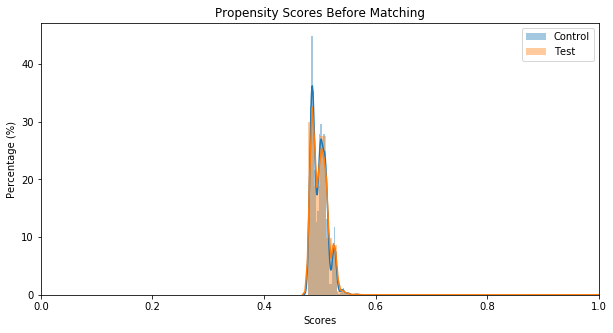

In [88]:
m.plot_scores()

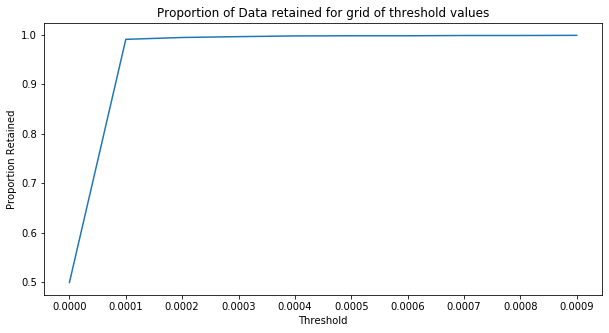

In [89]:
m.tune_threshold(method='random')

In [90]:
m.match(method="min", nmatches=1, threshold=0.0001)
m.record_frequency()

,freq,n_records
0,1,4276
1,2,360
...,...,...
19,108,1
20,143,1


In [91]:
m.matched_data.sort_values("match_id").head(6)

,c_rating,citizenship,city_size,cumulative_gpa,gender,mock_treatment,scores,match_id,record_id
0,B,U. S. Citizen,City,2.8974,Female,1,0.489419,0,0
4139,A,U. S. Citizen,City,3.4535,Female,0,0.489415,0,4139
...,...,...,...,...,...,...,...,...,...
2,A,U. S. Citizen,City,2.8754,Male,1,0.508727,2,2
3482,A,U. S. Citizen,City,2.8754,Male,0,0.508727,2,3482


In [106]:
matched_treatment = m.matched_data.sort_values("match_id")
matched_treatment = matched_treatment.loc[matched_treatment['mock_treatment'] == 1]
print(matched_treatment['cumulative_gpa'].mean()) 


matched_control = m.matched_data.sort_values("match_id")
matched_control = matched_control.loc[matched_control['mock_treatment'] == 0]
print(matched_control['cumulative_gpa'].mean()) 

2.566840178314642
2.55439807305148


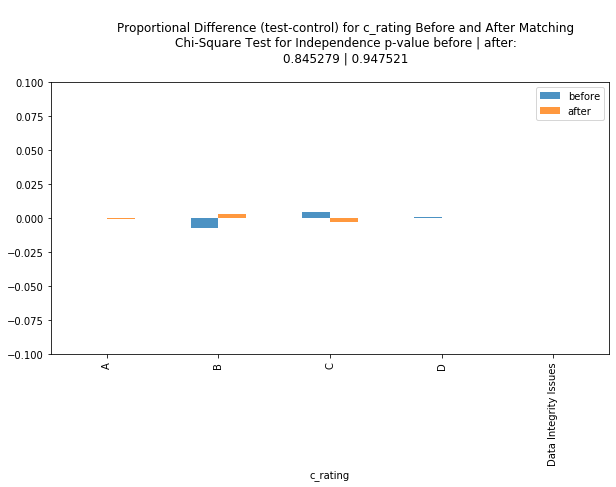

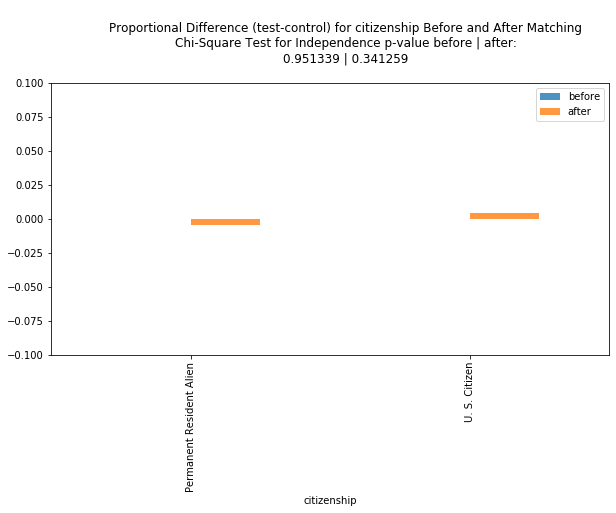

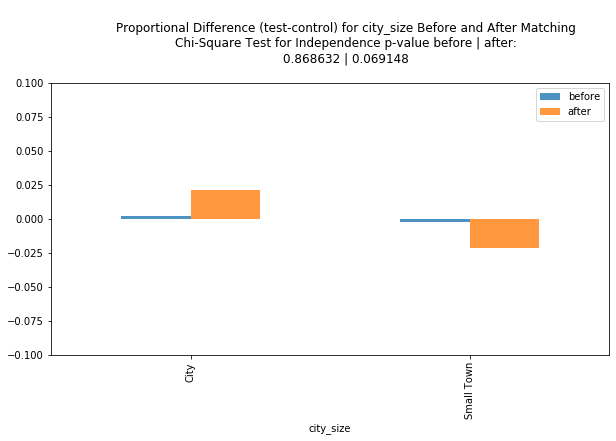

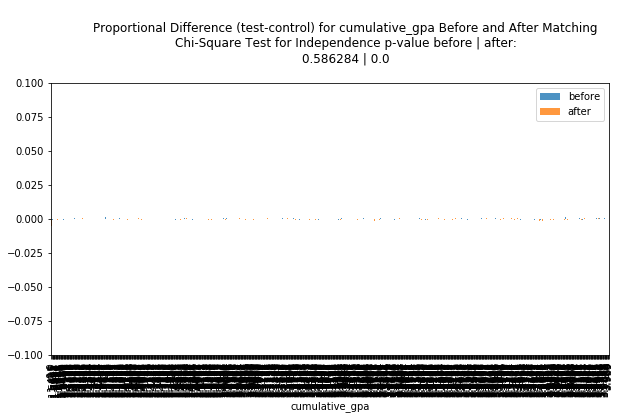

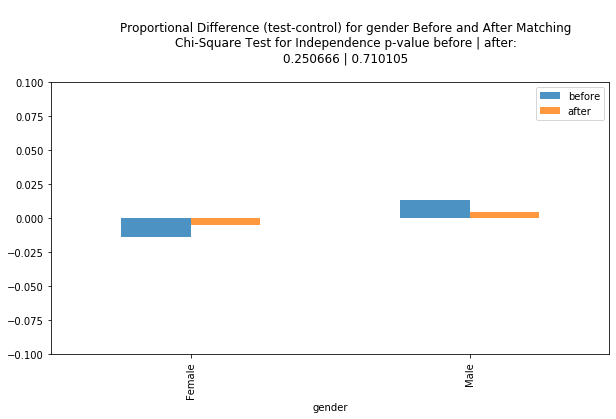

In [92]:
categorical_results = m.compare_categorical(return_table=True)

In [71]:
cc = m.compare_continuous(return_table=True)

KeyError: "None of [Index(['var', 'ks_before', 'ks_after', 'grouped_chisqr_before',\n       'grouped_chisqr_after', 'std_median_diff_before',\n       'std_median_diff_after', 'std_mean_diff_before', 'std_mean_diff_after'],\n      dtype='object')] are in the [columns]"

In [ ]:
#Import Library
#Import other necessary libraries like pandas, numpy...
from sklearn import tree
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create tree object 
#model = tree.DecisionTreeClassifier(criterion='gini') # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
model = tree.DecisionTreeRegressor() for regression
# Train the model using the training sets and check score
model.fit(X, y)
model.score(X, y)
#Predict Output
predicted= model.predict(x_test)